# This is my 36th. House Rent Price Prediction Project

# Import Required Libraries

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost
from xgboost import XGBRegressor

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Save the model
import joblib

# Load Dataset

In [2]:
data = pd.read_csv('data.csv')
data.head()

,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897.0,2,2,0,Semi-Furnished,134.0,120000.0
1,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490.0,1,1,0,Semi-Furnished,82.0,40000.0
2,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550.0,1,1,0,Unfurnished,22.0,12000.0
3,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000.0,2,2,0,Unfurnished,8.0,8000.0
4,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595.0,1,1,0,Unfurnished,25.0,15000.0


# Check Duplicates & Basic Info

In [3]:
data.duplicated().sum()

0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   house_type  7691 non-null   object 
 1   locality    7691 non-null   object 
 2   city        7691 non-null   object 
 3   area        7691 non-null   float64
 4   beds        7691 non-null   int64  
 5   bathrooms   7691 non-null   int64  
 6   balconies   7691 non-null   int64  
 7   furnishing  7691 non-null   object 
 8   area_rate   7691 non-null   float64
 9   rent        7691 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 601.0+ KB


# Identify Categorical Columns

In [5]:
cat = data.select_dtypes(include='object')
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].nunique()}")

house_type
5467
locality
1984
city
5
furnishing
3


In [6]:
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].unique()}")

house_type
['2 BHK Flat for Rent in Oberoi Woods, Goregaon East, Mumbai'
 '1 BHK Flat for Rent in Sapphire Lakeside, Powai, Mumbai'
 '1 BHK House for Rent in Mundhwa Pune' ...
 '1 BHK Flat for Rent in Link View, IC Colony, Mumbai'
 '2 BHK Flat for Rent in Malpani Vivanta, Balewadi, Pune'
 '2 BHK Flat for Rent in Govindpura, Dooravani Nagar, Bangalore']
locality
['Goregaon East' 'Powai' 'Mundhwa' ... 'Anjanapura Township'
 'Qutub Vihar Phase 2' 'Govindpura']
city
['Mumbai' 'Pune' 'Nagpur' 'Bangalore' 'New Delhi']
furnishing
['Semi-Furnished' 'Unfurnished' 'Furnished']


# Extract BHK from house_type

In [7]:
data['BHK'] = (data['house_type'].str.extract(r'(\d+)\s*BHK').astype(float))

# Create Property_Type Feature

In [8]:
data['Property_Type'] = np.where(data['house_type'].str.contains('Flat', case=False),
                                 'Flat',np.where(data['house_type'].str.contains('House', case=False),'House','Other'))


In [9]:
data['Property_Type'].value_counts()

Property_Type
Flat     5896
House    1557
Other     238
Name: count, dtype: int64

# Drop house_type Column

In [10]:
data.drop(columns=['house_type'], inplace=True)

# Clean locality Column

In [11]:
# Convert to lowercase
data['locality'] = data['locality'].str.lower()

# Remove extra spaces
data['locality'] = data['locality'].str.strip()

# Remove special characters (keep letters & spaces)
data['locality'] = data['locality'].str.replace(r'[^a-z\s]', '', regex=True)

# Replace multiple spaces with single space
data['locality'] = data['locality'].str.replace(r'\s+', ' ', regex=True)

# Handle missing values
data['locality'] = data['locality'].fillna('unknown')


In [12]:
data.head(2)

,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent,BHK,Property_Type
0,goregaon east,Mumbai,897.0,2,2,0,Semi-Furnished,134.0,120000.0,2.0,Flat
1,powai,Mumbai,490.0,1,1,0,Semi-Furnished,82.0,40000.0,1.0,Flat


# Label Encode Categorical Columns

In [13]:
le = LabelEncoder()
cat = data.select_dtypes(include='object').columns
for i in cat:
    data[i] = le.fit_transform(data[i])

data.head()

,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent,BHK,Property_Type
0,571,1,897.0,2,2,0,1,134.0,120000.0,2.0,0
1,1368,1,490.0,1,1,0,1,82.0,40000.0,1.0,0
2,1158,4,550.0,1,1,0,2,22.0,12000.0,1.0,1
3,652,2,1000.0,2,2,0,2,8.0,8000.0,2.0,0
4,1120,1,595.0,1,1,0,2,25.0,15000.0,1.0,0


# Define Features & Target Train-Test Split

In [14]:
X = data.drop(['rent'],axis=1)
y = data['rent']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

scaler = StandardScaler()

#scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape,X_test_scaled.shape

((6152, 10), (1539, 10))

# Preprocessing Pipeline

In [15]:
preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Baseline Model Comparison

In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=537),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=537),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=537),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=537),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=537)
}

In [17]:
results = []

for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "RMSE": rmse,
        'MAE': mae,
        "R2 Score": r2
    })
    
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
results_df

,Model,RMSE,MAE,R2 Score
6,XGBoost,12964.770649,2678.482968,0.977571
4,Extra Trees,16014.967981,2455.389727,0.965776
2,Gradient Boosting,17933.022625,4707.203621,0.957087
1,Random Forest,21308.061620,2404.679448,0.939415
5,K-Nearest Neighbors,39231.443895,15189.770110,0.794625
3,AdaBoost,60187.452717,51729.000962,0.516617
0,Linear Regression,62930.646844,25399.892751,0.471550


# Hyperparameter Tuning (GridSearchCV)

In [18]:
models = {
    # -------------------------------
    "XGBoost": {
        "model": XGBRegressor(objective="reg:squarederror", random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    },
    # -------------------------------
    "Linear Regression": {
        "model": LinearRegression(),
        "param_grid": {
            "fit_intercept": [True, False],
            "copy_X": [True, False]
        }
    },
    # -------------------------------
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "param_grid": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    # -------------------------------
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    # -------------------------------
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    # -------------------------------
    "Extra Trees": {
        "model": ExtraTreesRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "K-Nearest Neighbors": {
        "model": KNeighborsRegressor(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        }
    },
    # -------------------------------
    "MLP Regressor": {
        "model": MLPRegressor(random_state=42, max_iter=500),
        "param_grid": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu", "tanh"],
            "solver": ["adam"],
            "learning_rate_init": [0.001, 0.01]
        }
    }
}

print(f" Total Regression Models Loaded: {len(models)}")

 Total Regression Models Loaded: 9


# Best Model Evaluation

In [23]:
results = []
best_score = -float('inf')
best_model = None
best_name = None

for name, config in models.items(): 
    print(f"\n Running GridSearchCV for {name}...")
    
    model = config["model"]
    param_grid = config["param_grid"]
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

    print(f" {name} Best CV R²: {grid.best_score_:.4f}")
    print(f"   Best Params: {grid.best_params_}")

    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

print("\n Summary Results:")
print(results_df)

print(f"\n Best Model: {best_name}")
print(f" Best CV Score (R²): {best_score:.4f}")


 Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
 XGBoost Best CV R²: 0.9209
   Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

 Running GridSearchCV for Linear Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Linear Regression Best CV R²: 0.4486
   Best Params: {'copy_X': True, 'fit_intercept': True}

 Running GridSearchCV for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
 Decision Tree Best CV R²: 0.9002
   Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

 Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
 Random Forest Best CV R²: 0.9182
   Best Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

 Running GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 12 candidate

# Predicted vs Actual Plot

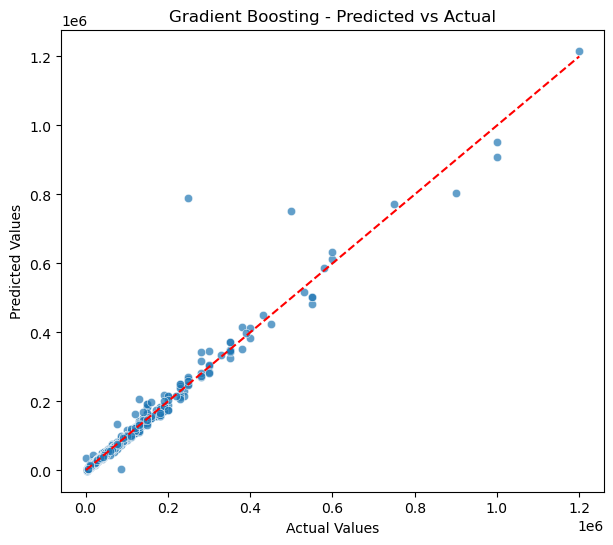

In [24]:
y_pred = best_model.predict(X_test)

# Scatter Plot: Predicted vs Actual
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_name} - Predicted vs Actual")
plt.show()

# Residuals Distribution

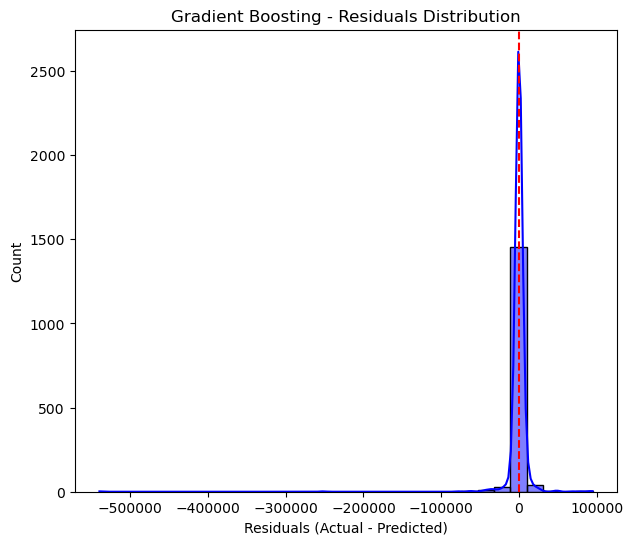

In [25]:
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title(f"{best_name} - Residuals Distribution")
plt.show()

# Feature Importance

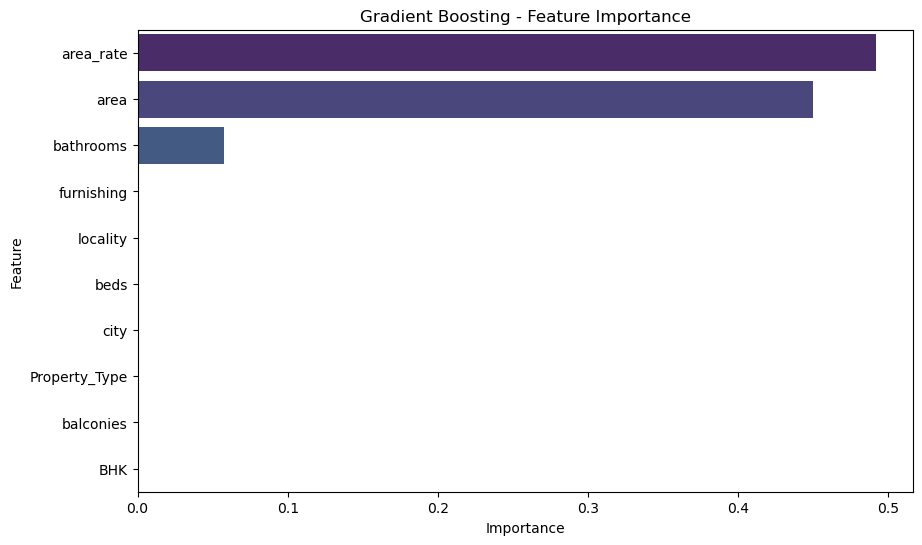

In [26]:
if hasattr(best_model, "feature_importances_"):
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": best_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
    plt.title(f"{best_name} - Feature Importance")
    plt.show()
else:
    print(f" Feature importance not available for {best_name}")

# Save The Model

In [27]:
feature_columns = X.columns.to_list()
joblib.dump(feature_columns,'features 36.House Rent Price Prediction.joblib')

['features 36.House Rent Price Prediction.joblib']

In [28]:
joblib.dump(best_model,'best model 36.House Rent Price Prediction.joblib')

['best model 36.House Rent Price Prediction.joblib']

# If you have any suggestions, please DM me.
# Even a small message from you can make a big impact on my career
#### I Am Arun